<a href="https://colab.research.google.com/github/pamela2412/Transfer-learning-Tarea/blob/main/transfer_learning_(tarea).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.


In [11]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"
import shutil
import random
import numpy as np
import keras
import zipfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000.

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

In [14]:
# Descargar el dataset
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

# Definir la ruta del archivo ZIP
local_zip = "/tmp/cats-and-dogs.zip"

# Verificar si el archivo existe antes de extraer
if os.path.exists(local_zip):
    print("✅ Archivo descargado correctamente. Extrayendo...")

    # Extraer el contenido del ZIP
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall('/tmp')

    print("✅ Extracción completada.")
else:
    print("❌ Error: No se encontró el archivo ZIP.")


--2025-02-08 20:37:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.29.22.44, 2600:1406:5400:3a3::317f, 2600:1406:5400:395::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.29.22.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   132MB/s    in 6.1s    

2025-02-08 20:37:25 (129 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]

✅ Archivo descargado correctamente. Extrayendo...
✅ Extracción completada.


In [15]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass


In [34]:

import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


# Directorios base
base_dir = "/tmp/PetImages"
train_dir = "/tmp/cats-v-dogs/training"
val_dir = "/tmp/cats-v-dogs/validation"
test_dir = "/tmp/cats-v-dogs/testing"

# Crear carpetas si no existen
for directory in [train_dir, val_dir, test_dir]:
    for category in ["cats", "dogs"]:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Función para verificar si el archivo es una imagen válida
def es_imagen_valida(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()  # Verifica si la imagen es válida
        return True
    except (IOError, SyntaxError):  # Captura excepciones si no es una imagen válida
        return False

# Función para dividir imágenes en entrenamiento, validación y test
def split_data(source, training, validation, testing, train_size=0.7, val_size=0.15, test_size=0.15):
    # Verificar que los tamaños sumen 1
    assert train_size + val_size + test_size == 1.0, "La suma de los tamaños debe ser 1"

    files = os.listdir(source)
    files = [f for f in files if f.endswith((".jpg", ".png", ".jpeg"))]  # Filtrar solo imágenes
    files = [f for f in files if es_imagen_valida(os.path.join(source, f))]  # Filtrar imágenes válidas
    random.shuffle(files)  # Mezclar datos

    train_count = int(len(files) * train_size)
    val_count = int(len(files) * val_size)
    test_count = len(files) - train_count - val_count  # El resto va para test

    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:]

    # Copiar a las carpetas correspondientes
    for f in train_files:
        shutil.copy(os.path.join(source, f), os.path.join(training, f))

    for f in val_files:
        shutil.copy(os.path.join(source, f), os.path.join(validation, f))

    for f in test_files:
        shutil.copy(os.path.join(source, f), os.path.join(testing, f))

# Separar imágenes de gatos
split_data(base_dir + "/Cat", train_dir + "/cats", val_dir + "/cats", test_dir + "/cats")

# Separar imágenes de perros
split_data(base_dir + "/Dog", train_dir + "/dogs", val_dir + "/dogs", test_dir + "/dogs")

# Ahora que tenemos los datos divididos, vamos a cargar las imágenes usando ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza los valores entre 0 y 1
val_datagen = ImageDataGenerator(rescale=1./255)    # Solo normaliza

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Tamaño de imagen objetivo
    batch_size=32,
    class_mode='categorical'      # Clasificación binaria (gatos y perros)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)    # Solo normaliza
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Resumen después de cargar los datos
num_classes = 2  # Gatos y perros
print("finished loading %d images from %d categories" % (train_generator.samples + val_generator.samples + test_generator.samples, num_classes))
print("train / validation / test split: %d, %d, %d" % (train_generator.samples, val_generator.samples, test_generator.samples))
print("training data shape: ", train_generator[0][0].shape)  # Forma del primer batch de imágenes de entrenamiento
print("training labels shape: ", train_generator[0][1].shape)  # Forma de las etiquetas de entrenamiento





/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Found 24998 images belonging to 2 classes.
Found 11949 images belonging to 2 classes.
Found 18268 images belonging to 2 classes.
finished loading 55215 images from 2 categories
train / validation / test split: 24998, 11949, 18268
training data shape:  (32, 224, 224, 3)
training labels shape:  (32, 2)


In [45]:
x_train, y_train = next(train_generator)
x_val, y_val = next(val_generator)
x_text, y_test =next(test_generator)

# Verifica las dimensiones de los datos
print("Training data shape: ", x_train.shape)
print("Validation data shape: ", x_val.shape)

Training data shape:  (32, 224, 224, 3)
Validation data shape:  (32, 224, 224, 3)


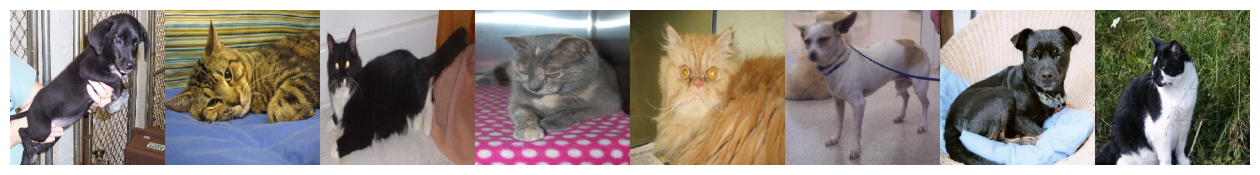

In [36]:
root = "/tmp/PetImages"  # Asegúrate de modificar esto según tu directorio de imágenes

# Buscar todas las imágenes .jpg, .png, .jpeg en el directorio raíz y sus subdirectorios
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]

# Seleccionar aleatoriamente 8 índices
idx = [int(len(images) * random.random()) for i in range(8)]

# Cargar y redimensionar las imágenes seleccionadas
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

# Concatenar las imágenes horizontalmente
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

# Mostrar la imagen concatenada
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)
plt.axis('off')  # Desactivar los ejes
plt.show()

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [37]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adadelta

# Asegúrate de que x_train, x_val, y_train y y_val están listos y normalizados correctamente

# Número de clases (por ejemplo, gatos y perros)
num_classes = 2

# Definir el modelo
model = Sequential()
print("Input dimensions: ", x_train.shape[1:])

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:])) # La entrada es (224, 224, 3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de dropout
model.add(Dropout(0.25))

# Tercera capa convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarta capa convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de dropout
model.add(Dropout(0.25))

# Aplanado
model.add(Flatten())

# Capa completamente conectada con 256 neuronas
model.add(Dense(256))
model.add(Activation('relu'))

# Capa de dropout
model.add(Dropout(0.5))

# Capa de salida (softmax para clasificación multiclase)
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Resumen del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer=Adadelta(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_34 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [47]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5938 - loss: 0.6974 - val_accuracy: 0.3750 - val_loss: 0.8015
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5312 - loss: 0.8220 - val_accuracy: 0.6250 - val_loss: 0.6750
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5000 - loss: 0.7770 - val_accuracy: 0.6250 - val_loss: 0.6764
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5312 - loss: 0.7406 - val_accuracy: 0.5000 - val_loss: 0.6891
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4688 - loss: 0.7049 - val_accuracy: 0.3750 - val_loss: 0.6989
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5625 - loss: 0.6814 - val_accuracy: 0.3750 - val_loss: 0.7042
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5625 - loss: 0.6662 - val_accuracy: 0.3750 - val_loss: 0.7086
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5312 - loss: 0.6682 - val_accuracy: 0.3750 - val_loss: 0.

Let's plot the validation loss and validation accuracy over time.

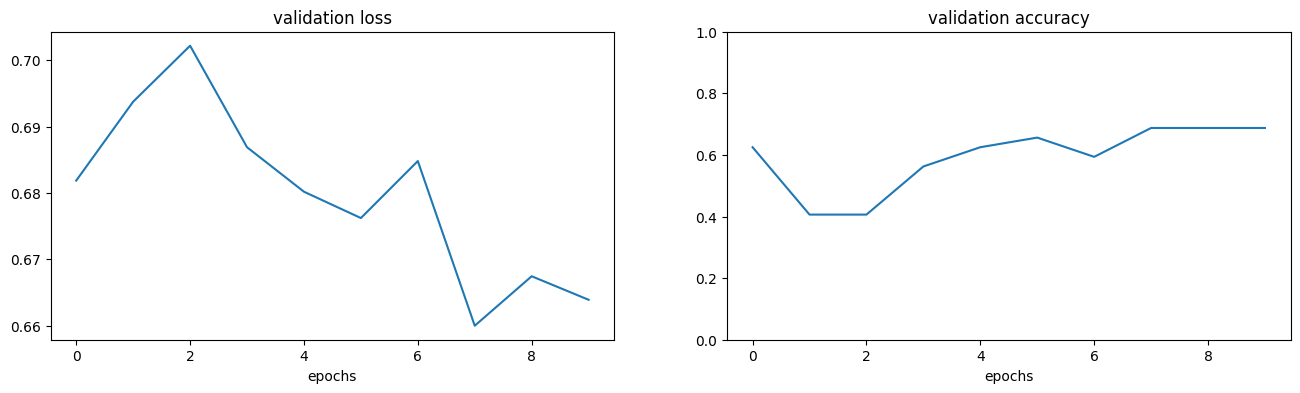

In [42]:
fig = plt.figure(figsize=(16, 4))

# Subgráfico para la pérdida de validación
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

# Subgráfico para la precisión de validación
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])  # Cambiado 'val_acc' por 'val_accuracy'
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()


Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [49]:
loss, accuracy = model.evaluate(x_text, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6961452960968018
Test accuracy: 0.53125


Finally, we see that we have achieved a (top-1) accuracy of around 49%. That's not too bad for 6000 images, considering that if we were to use a naive strategy of taking random guesses, we would have only gotten around 1% accuracy.

## Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [50]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [51]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [52]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [53]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.4688 - loss: 0.7848 - val_accuracy: 0.3750 - val_loss: 1.6372
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5312 - loss: 1.3970 - val_accuracy: 0.3750 - val_loss: 1.0266
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5312 - loss: 0.9399 - val_accuracy: 0.8125 - val_loss: 0.5265
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6875 - loss: 0.6542 - val_accuracy: 0.6250 - val_loss: 0.6816
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.4688 - loss: 0.9547 - val_accuracy: 0.6250 - val_loss: 0.6329
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.4688 - loss: 0.8778 - val_accuracy: 0.8125 - val_loss: 0.4986
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6562 - loss: 0.6232 - val_accuracy: 0.5312 - val_loss: 0.6146
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5312 - loss: 0.6231 - val_accuracy: 0.3750 - val_loss: 0.81

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%).

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

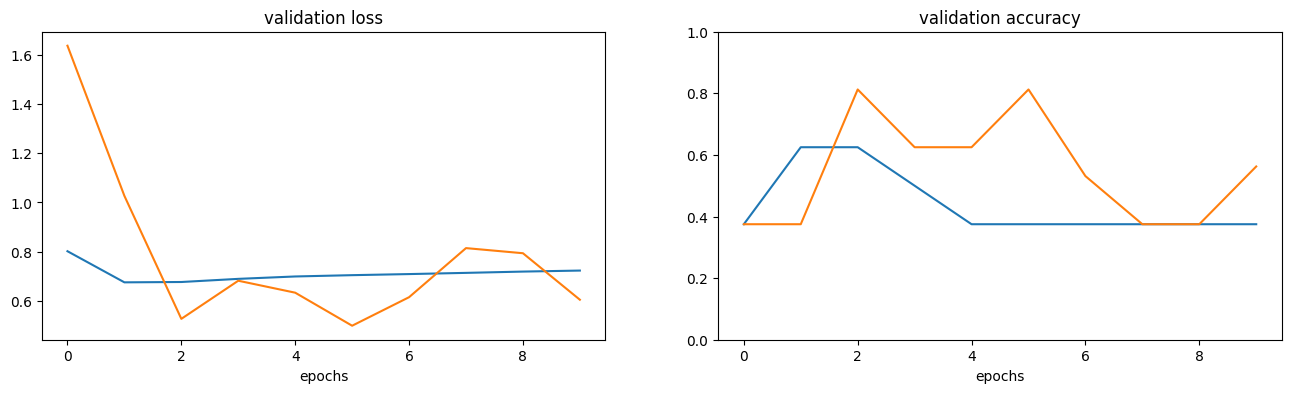

In [55]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy.

Again, we do a final validation on the test set.

In [57]:
loss, accuracy = model_new.evaluate(x_text, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6416912078857422
Test accuracy: 0.625


To predict a new image, simply run the following code to get the probabilities for each class.

In [60]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Función para cargar y preprocesar la imagen
def cargar_imagen(filepath):
    # Cargar la imagen desde el archivo
    img = image.load_img(filepath, target_size=(224, 224))  # Asegúrate de que el tamaño de la imagen coincida con el esperado por el modelo
    img_array = image.img_to_array(img)  # Convertir la imagen a un array de NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión extra para el batch (tamaño del lote)
    img_array = img_array / 255.0  # Normalizar la imagen (ya que el modelo espera valores entre 0 y 1)
    return img, img_array

# Cargar la imagen y preprocesarla
img, x = cargar_imagen('/tmp/cats-v-dogs/testing/dogs/1.jpg')

# Hacer una predicción con el modelo
probabilidades = model_new.predict(x)
print(probabilidades)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.11650687 0.8834931 ]]


### Improving the results

78.2% top-1 accuracy on 97 classes, roughly evenly distributed, is a pretty good achievement. It is not quite as impressive as the original VGG16 which achieved 73% top-1 accuracy on 1000 classes. Nevertheless, it is much better than what we were able to achieve with our original network, and there is room for improvement. Some techniques which possibly could have improved our performance.

- Using data augementation: augmentation refers to using various modifications of the original training data, in the form of distortions, rotations, rescalings, lighting changes, etc to increase the size of the training set and create more tolerance for such distortions.
- Using a different optimizer, adding more regularization/dropout, and other hyperparameters.
- Training for longer (of course)

A more advanced example of transfer learning in Keras, involving augmentation for a small 2-class dataset, can be found in the [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).